# Поиск по изображениям

**Цель проекта**: - разработать демонстрационную версию поиска изображений по запросу.<br>
Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

**План работ**:
1. Загрузить данные и провести исследовательский анализ данных
  
2. Подготовить данные к обучению модели: 
    - Создать список слов, которые могут попадать под юридические ограничения.
    - Исключить из обучающего датасета пары, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.
    - Сделайть векторизацию текстового описания
    - Сделайть векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.

      
3. Обучить модель:
    - Создайть модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.
    - Выбрать метрику, по которой вы будете сравнивать точность различных моделей.
    - Обучить несколько моделей и подобрать их гиперпараметры. В качестве моделей обязательно нужно рассмотреть: Линейную регрессию; Полносвязные нейронные сети.
      
4. Протестировать модель:
    - Провести тестирование лучшей модели на тестовых данных.


In [1]:
from keras.datasets import fashion_mnist
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Conv1D,AveragePooling2D
from keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torchvision.models as models
import torch
import transformers 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import os
from gensim.models import Word2Vec

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
import optuna
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import logging


## Загрузка данных

### Описание данных

В файле **train_dataset.csv** находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке **train_images** содержатся изображения для тренировки модели.

В файле **CrowdAnnotations.tsv**  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.

В файле **ExpertAnnotations.tsv**  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов. 
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.    

В файле **test_queries.csv** находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке **test_images** содержатся изображения для тестирования модели.

### Загрузка данных и анализ

In [2]:
path = '/kaggle/input/dsplus-integrated-project-4/to_upload'

Укажем наименования столбцов для корректной загрузки для файлов ExpertAnnotations и CrowdAnnotations.

In [3]:
column_names_experts = ['image', 'query_id', 'expert1', 'expert2','expert3']
column_names_crowd = ['image', 'query_id', 'part_matches', 'count_matches','count_no_matches']

In [4]:
try:
    data_train = pd.read_csv(path+'/train_dataset.csv', sep = ',')
    data_experts = pd.read_csv(path+'/ExpertAnnotations.tsv', sep = '\t', names = column_names_experts)
    data_crowd = pd.read_csv(path+'/CrowdAnnotations.tsv', sep = '\t', names = column_names_crowd)
    test_queries = pd.read_csv(path+'/test_queries.csv', sep = '|')

except FileNotFoundError:
    print('Файл не найден. Необходимо проверить путь к файлу')
except Exception:
    print('Файл не загрузился')

In [5]:
data_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [6]:
data_experts.head()

image                     query_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

In [7]:
data_crowd.head()

image                     query_id  part_matches  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   count_matches  count_no_matches  
0              3                 0  
1              0                 3  
2              0                 3  
3              0                 3  
4              0                 3

In [8]:
test_queries.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Посмотрим детальнее на информацию, представленную в таблицах, и на сами изображения.

In [9]:
len(data_train['image'].unique())

1000

In [10]:
len(test_queries['image'].unique())

100

Всего 1000 уникальных изображений в тренировочных данных и 100 уникальных изображений в тестовых данных. Если мы посмотрим содержимое папок, то увилим, что там тоже 1000 тренировочных изображений и 100 тестовых.

In [11]:
len(data_train['query_id'].unique())

977

In [12]:
len(test_queries['query_id'].unique())

500

Всего 977 уникальных запросов в тренировочных данных - практически по одному на изображение. И всего 500 уникальных запросов в тестовых данных - может быть по 5 описаний на каждое изображение.

In [13]:
data_train.describe()

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

In [14]:
data_experts.describe()

expert1      expert2      expert3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

В тренировочных данных 5822 строки. Для каждой строки (соответствия изображение - запрос - описание) есть экспертные оценки. Оценки получены от трех экспертов, соответственно три столбца. Оценки принимают значения от 1 до 4 (от несоответствия до полного соответствия). В среднем от 1,4 до 1,9, т.е. чаще не соответствуют.

In [15]:
data_crowd.describe()

part_matches  count_matches  count_no_matches
count  47830.000000   47830.000000      47830.000000
mean       0.068786       0.208488          2.820155
std        0.207532       0.628898          0.656676
min        0.000000       0.000000          0.000000
25%        0.000000       0.000000          3.000000
50%        0.000000       0.000000          3.000000
75%        0.000000       0.000000          3.000000
max        1.000000       5.000000          6.000000

Всего 47830 краудсорсинговых оценок. Доля людей, подтвердивших соответствие от 0 до 1 и в среднем составляет 0,069. Количество людей, подтвердивших и не подтвердивших соответствие, колеблется между 0 и 5-6.

В целом будем больше опираться на экспертные оценки, они более точные. Краудсорсинговые оценки нужно будет обрабатывать осторожно, строк с ними значительно больше, чем строк с экспертными оценками. Далее для оценок введем веса, больший вес будет у экспертной оценки.

Также заметим, что в query_id содержится имя изображения, которому он соотвествует. Это мы можем использовать на этапе чистки запрещенных изображений (находить запрещенные слова в описании, брать этот query_id и отсечь изображения с номерами image = найденным query_id).

In [16]:
def display_images_from_folder(folder_path, num_images=10, cols=5, figsize=(15, 10)):
    # Получаем список изображений в папке
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_files = image_files[:num_images]  # Берем только нужное количество
    
    # Рассчитываем количество строк
    rows = (num_images + cols - 1) // cols
    
    # Создаем grid
    plt.figure(figsize=figsize)
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = Image.open(img_path)
            
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.title(os.path.basename(img_file)[:15] + '...', fontsize=8)  # Обрезаем длинные названия
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_file}: {e}")
    
    plt.tight_layout()
    plt.show()


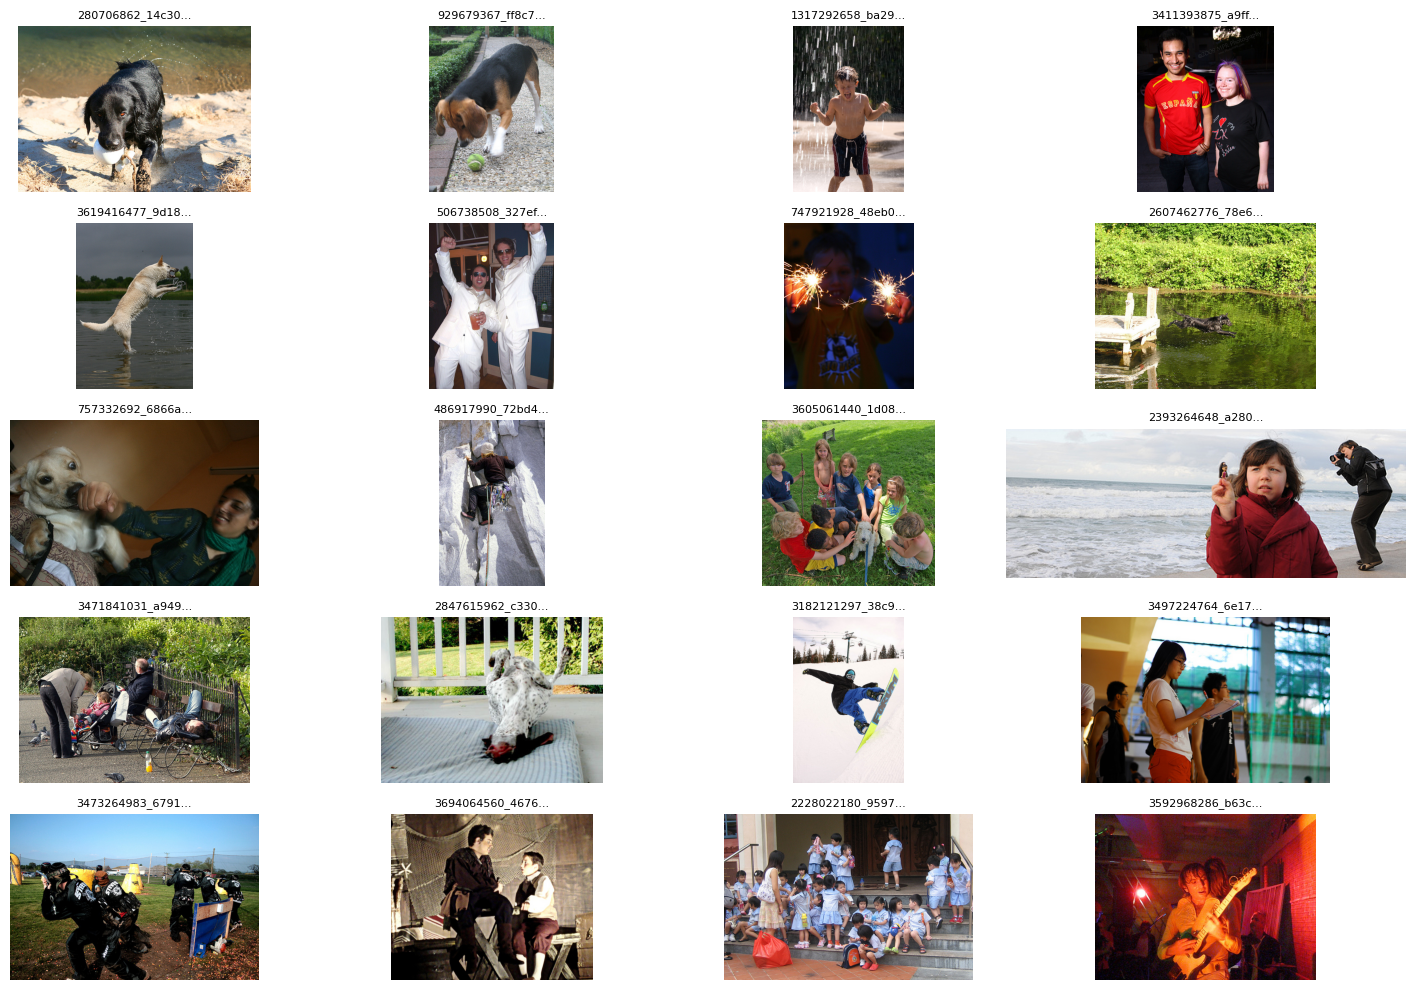

In [17]:
folder_path = path+'/train_images'
display_images_from_folder(folder_path, num_images=20, cols=4)

Вывели несколько тренировочных изображений. На них изображены взрослые, дети, животные, виды спорта. Не все фотографии четкие, яркие. Наблюдаем у людей и животных различные положения и занятия. На ком-то костюмы, очки, где-то на передний план выходят второстепенные элементы, а остальная часть фото затемнена.

В data_train в столбце query_id есть символы #2, но чтобы свзять их с номерами изображений, обрежем эту часть в query_id

In [18]:
data_train['query_id'] = data_train['query_id'].str[:-2]

In [19]:
#data_train['query_text'].unique()

#### Юридические ограничения

По законам необходимо избегать материалов, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
В связи с этим необходимо очистить данные от проблемного контента.

При тестировании при попытке посмотреть изображения, запрещённые законодательством, вместо картинок должен показываться дисклеймер:
⎢ This image is unavailable in your country in compliance with local laws.

Найдем текстовые описания, характерные для детей, т.е. со словами child, kid, boy, girl,..
Т.к. в query_id содержится номер "родного" изображения, для которого и было составлено описание, сможем составить список запрещенных изображений и удалить их из выборки.

In [20]:
# Список запрещенных слов
banned_words = ['boy', 'girl', 'child', 'kid', 'baby']

# Создаем регулярное выражение для поиска запрещенных слов
regex_pattern = '|'.join(banned_words)

# Фильтруем строки, где нет запрещенных слов
images_banned = data_train[data_train['query_text'].str.contains(regex_pattern, case=False, regex=True)]['query_id'].drop_duplicates().to_list()

In [21]:
data_train_filtered = data_train[~data_train['image'].isin(images_banned)]

In [22]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [23]:
data_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4110 entries, 0 to 5820
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4110 non-null   object
 1   query_id    4110 non-null   object
 2   query_text  4110 non-null   object
dtypes: object(3)
memory usage: 128.4+ KB


Из датасета убрали "запрещенные" изображения, осталось 4110 строк: пар изображение - текстовое описание.

In [24]:
data_experts['query_id'] = data_experts['query_id'].str[:-2]
data_crowd['query_id'] = data_crowd['query_id'].str[:-2]

#### Вывод финальной оценки соответствия описания изображению

Рассмотрим сначала данные экспертов
Будем определять финальную оценку трех экспертов по правилу большинства.
Для начала удалим строки, где все оценки экспертов различны, там нельзя определить оценку по правилу большинства.

In [25]:
data_experts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert1   5822 non-null   int64 
 3   expert2   5822 non-null   int64 
 4   expert3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [26]:
data_experts = data_experts[(data_experts['expert1']==data_experts['expert2'])|(data_experts['expert1']==data_experts['expert3'])|(data_experts['expert3']==data_experts['expert2'])]

In [27]:
# Вычисляем моду для каждой строки по полям expert1, expert2, expert3
data_experts['expert_common'] = data_experts[['expert1', 'expert2', 'expert3']].mode(axis=1)[0]

# Выводим результат
data_experts.head()

image                   query_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg        1        1   

   expert3  expert_common  
0        1              1  
1        2              1  
2        2              1  
3        2              2  
4        2              1

In [28]:
data_experts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5696 non-null   object
 1   query_id       5696 non-null   object
 2   expert1        5696 non-null   int64 
 3   expert2        5696 non-null   int64 
 4   expert3        5696 non-null   int64 
 5   expert_common  5696 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 311.5+ KB


После удаления строк с различными экспертными оценками количество строк уменьшилось: c 5822 стало 5696.

Добавили поле **Expert_common** с финальной оценкой экспертов.
Теперь рассмотрим оценки, полученные краудсорсингом.

In [29]:
data_crowd.head()

image                   query_id  part_matches  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg           0.0   

   count_matches  count_no_matches  
0              3                 0  
1              0                 3  
2              0                 3  
3              0                 3  
4              0                 3

In [30]:
data_crowd[(data_crowd['count_matches']+data_crowd['count_no_matches'])==0]

Empty DataFrame
Columns: [image, query_id, part_matches, count_matches, count_no_matches]
Index: []

In [31]:
data_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   part_matches      47830 non-null  float64
 3   count_matches     47830 non-null  int64  
 4   count_no_matches  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В данных краудсорсинга гораздо больше строк. Используем за базу данные экспертов и присоединим к ним оценки краудсорсинга.

In [32]:
data_marks = pd.merge(data_experts, data_crowd, on=['image', 'query_id'], how='left')

In [33]:
data_marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5696 non-null   object 
 1   query_id          5696 non-null   object 
 2   expert1           5696 non-null   int64  
 3   expert2           5696 non-null   int64  
 4   expert3           5696 non-null   int64  
 5   expert_common     5696 non-null   int64  
 6   part_matches      2258 non-null   float64
 7   count_matches     2258 non-null   float64
 8   count_no_matches  2258 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 400.6+ KB


Получили таблицу с оценками соответствия **data_marks**. В ней 5696 строк.
Экспертные оценки заполнены, а краудсорсинговые менее, чем в половине случаев.

Далее приведем экспертную оценку к формату от 0 до 1 посредством MinMaxScale.

Будем брать экспертную оценку с коэффициентом 0,6, а краудсорсинговую с коэффициентом 0,4. Если краудсорсинговой оценки нет, то возьмем только экспертную.

In [34]:
# Применяем масштабирование к столбцу
data_marks['expert_scaled'] = (data_marks[['expert_common']]-1)/3
# Создаем коэффициент 0,6 к экспертной оценке
data_marks['mark_final'] = np.where(data_marks['part_matches'].isna(), 1, 0.6)

In [35]:
data_marks['part_matches'] = data_marks['part_matches'].fillna(-1)

In [36]:
data_marks["mark_final"] = (1 - data_marks["mark_final"]) * data_marks[
    "part_matches"
] + data_marks["mark_final"] * data_marks["expert_scaled"]

In [37]:
data_marks.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


image                   query_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg        1        1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg        1        1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg        1        1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg        1        1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg        1        1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg        2        2   

   expert3  expert_common  part_matches  count_matches  count_no_matches  \
0        1              1           0.0            0.0               3.0   
1        2              1           0.0            0.0               3.0   
2        2              1          -1.0            NaN               NaN   
3        2              2          -1.0            NaN               NaN   
4        2              1          -1.0            NaN               NaN   
5        1              1          -1.0            NaN               NaN   
6        1              1          -1.0            NaN               NaN   
7        2              1           0.0            0.0               3.0   
8        1              1          -1.0            NaN               NaN   
9        2              2          -1.0            NaN               NaN   

   expert_scaled  mark_final  
0       0.000000    0.000000  
1       0.000000    0.000000  
2       0.000000    0.000000  
3       0.333333    0.333333  
4       0.000000    0.000000  
5       0.000000    0.000000  
6       0.000000    0.000000  
7       0.000000    0.000000  
8       0.000000    0.000000  
9       0.333333    0.333333

In [38]:
data_marks.describe()

expert1      expert2      expert3  expert_common  part_matches  \
count  5696.000000  5696.000000  5696.000000    5696.000000   5696.000000   
mean      1.441713     1.611482     1.852353       1.611482     -0.524307   
std       0.792707     0.859100     0.889390       0.859100      0.626080   
min       1.000000     1.000000     1.000000       1.000000     -1.000000   
25%       1.000000     1.000000     1.000000       1.000000     -1.000000   
50%       1.000000     1.000000     2.000000       1.000000     -1.000000   
75%       2.000000     2.000000     2.000000       2.000000      0.000000   
max       4.000000     4.000000     4.000000       4.000000      1.000000   

       count_matches  count_no_matches  expert_scaled   mark_final  
count    2258.000000       2258.000000    5696.000000  5696.000000  
mean        0.608060          2.429584       0.203827     0.172265  
std         1.052485          1.065282       0.286367     0.261057  
min         0.000000          0.000000       0.000000     0.000000  
25%         0.000000          2.000000       0.000000     0.000000  
50%         0.000000          3.000000       0.000000     0.000000  
75%         1.000000          3.000000       0.333333     0.333333  
max         5.000000          6.000000       1.000000     1.000000

Получили финальную оценку в столбце mark_final. Она принимает значения от 0 до 1, но среднее значени и медиана малы, что означает дисбаланс классов.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


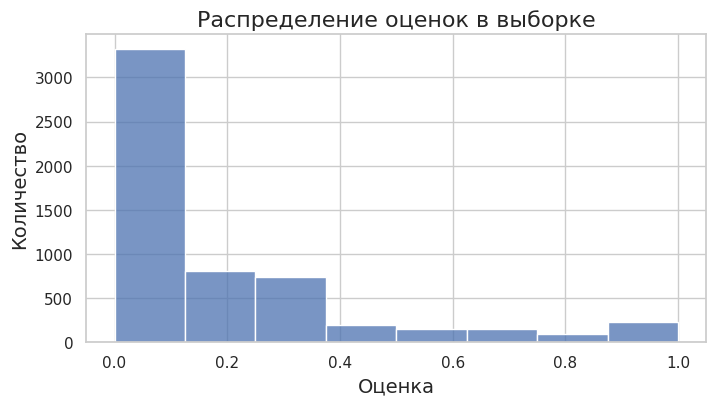

In [39]:
# Настройка стиля seaborn
sns.set(style="whitegrid")

# Построение распределения
plt.figure(figsize=(8, 4))
sns.histplot(data_marks['mark_final'], bins=8)
plt.title('Распределение оценок в выборке', fontsize=16)
plt.xlabel('Оценка', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.show()

#### Векторизация изображений

Векторизацию изображений проведем посредством предобученной сверточной сети ResNet50.

In [40]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель 
#не потребуется обучать модель, поэтому рекомендуем заморозить веса
for param in resnet.parameters():
    param.requires_grad_(False) 
# нужно взять все слои, кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
# перевести модель в режим предсказания
resnet.eval() 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 302MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [41]:
# Проверка размерности выхода
test_input = torch.randn(1, 3, 224, 224)
features = resnet(test_input)
print(f"Размерность выходных признаков: {features.shape[1]}")  # Для ResNet18 должно быть 512

Размерность выходных признаков: 512


In [42]:
from torchvision import transforms
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [43]:
image_folder_train = path + "/train_images/"
image_folder_test = path + "/test_images/"

In [44]:
# Получаем список всех изображений в папке
image_files_train = [f for f in os.listdir(image_folder_train) if f.endswith(('.jpg', '.png', '.jpeg'))]
image_files_test = [f for f in os.listdir(image_folder_test) if f.endswith(('.jpg', '.png', '.jpeg'))]

In [45]:
# функция векторизации изображений: на вход подаем номера изображений и папку с ними
def vect_image(image_files, image_folder):
    # Список для хранения векторов признаков
    feature_vectors = []
    
    # Проходим по всем изображениям
    for image_file in image_files:
        # Загружаем изображение
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path).convert('RGB')
    
        # Применяем преобразования и добавляем размерность батча
        image_tensor = preprocess(img).unsqueeze(0)  # Добавляем размерность батча
    
        # Получаем выходной вектор признаков
        with torch.no_grad():  # Отключаем вычисление градиентов
            output_tensor = resnet(image_tensor).flatten()
    
        # Сохраняем результат
        feature_vector = output_tensor.numpy()  # Переводим тензор в numpy
        feature_vectors.append((image_file, feature_vector))
    return feature_vectors

Применим полученную функуию векторизации изображений к тренировочным и тестовым изображениям.

In [46]:
feature_vectors = vect_image(image_files_train, image_folder_train)

In [47]:
feature_vectors_test = vect_image(image_files_test, image_folder_test)

In [48]:
len(feature_vectors)

1000

In [49]:
feature_vectors[0][1].shape

(512,)

Всего в папке с тренировочными изображениями 1000 фотографий, соответственно получили 1000 векторов.

In [50]:
# Преобразуем в датафрейм векторизованные изображения
data_image_vectors = pd.DataFrame(feature_vectors, columns=['image', 'feature_vector'])
# Преобразуем в датафрейм векторизованные изображения
data_image_vectors_test = pd.DataFrame(feature_vectors_test, columns=['image', 'feature_vector'])

#### Векторизация текстовых описаний

Текстовые описания небольшие, поэтому лемматизацию применять необязательно. Разделим их на токены и применим Word2Vec для векторизации текстовых описаний

In [51]:
data_train_filtered['query_text']

0       A young child is wearing blue goggles and sitt...
1       A young child is wearing blue goggles and sitt...
4       A young child is wearing blue goggles and sitt...
6       A young child is wearing blue goggles and sitt...
7       A young child is wearing blue goggles and sitt...
                              ...                        
5810    A man stands at the entrance of Yerba Buena Ce...
5811    Two men in black jackets behind a white handra...
5813    One person is on a ski lift while another snow...
5819         A dog stands on the side of a grassy cliff .
5820                         A blurry photo of two dogs .
Name: query_text, Length: 4110, dtype: object

In [52]:
from transformers import AutoTokenizer, AutoModel

# Загрузка предобученной модели и токенизатора
model_name = 'bert-base-uncased'  # или 'cointegrated/rubert-tiny' для русского
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bert = AutoModel.from_pretrained(model_name)

def text_to_bert_vector(text, model, tokenizer):
    # Токенизация текста
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    # Получение эмбеддингов
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Извлечение эмбеддингов [CLS] токена (для всего предложения)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    
    # Или усреднение эмбеддингов всех токенов:
    # mean_embedding = torch.mean(outputs.last_hidden_state, dim=1).numpy()
    
    return cls_embedding.squeeze()  # Удаляем лишнюю размерность

# Пример применения
text = "Пример текста для векторизации"
vector = text_to_bert_vector(text, model_bert, tokenizer)
print(f"Размерность вектора: {vector.shape}")

# Применение ко всему датасету
data_train_filtered['vector_text'] = data_train_filtered['query_text'].apply(
    lambda x: text_to_bert_vector(x, model_bert, tokenizer)
).tolist()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Размерность вектора: (768,)


<ipython-input-52-454f59211b49>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_filtered['vector_text'] = data_train_filtered['query_text'].apply(


In [53]:
# Размерность одного вектора
data_train_filtered['vector_text'][22].shape[0]

768

In [54]:
data_image_vectors.head()

image  \
0   280706862_14c30d734a.jpg   
1   929679367_ff8c7df2ee.jpg   
2  1317292658_ba29330a0b.jpg   
3  3411393875_a9ff73c67a.jpg   
4  3619416477_9d18580a14.jpg   

                                      feature_vector  
0  [1.2409891, 0.233476, 1.0955365, 0.6529077, 0....  
1  [0.3790385, 1.0550796, 0.42936435, 0.6719969, ...  
2  [0.55158794, 0.46660626, 0.7397678, 2.7227182,...  
3  [0.23827656, 0.5815115, 1.0759068, 1.6639528, ...  
4  [0.77599, 0.2814819, 0.45195296, 0.033599, 1.7...

In [55]:
data_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4110 entries, 0 to 5820
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        4110 non-null   object
 1   query_id     4110 non-null   object
 2   query_text   4110 non-null   object
 3   vector_text  4110 non-null   object
dtypes: object(4)
memory usage: 289.6+ KB


In [56]:
data_image_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           1000 non-null   object
 1   feature_vector  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


Как мы видим размерность векторизованных изображений и датафрейма с текстами разная, но это понятно, т.к. для одного изображения есть несколько описаний.
Преобразовать к одной форме можно, объединив их по полю image.

In [57]:
data_train = pd.merge(data_train_filtered, data_image_vectors, on = 'image', how = 'left')

In [58]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4110 entries, 0 to 4109
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           4110 non-null   object
 1   query_id        4110 non-null   object
 2   query_text      4110 non-null   object
 3   vector_text     4110 non-null   object
 4   feature_vector  4110 non-null   object
dtypes: object(5)
memory usage: 160.7+ KB


Также осталось 4110 фотографий и описаний. Объединим их с финальными оценками.

In [59]:
data_train = pd.merge(data_train, data_marks, on=['image', 'query_id'], how='inner')

In [60]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             4022 non-null   object 
 1   query_id          4022 non-null   object 
 2   query_text        4022 non-null   object 
 3   vector_text       4022 non-null   object 
 4   feature_vector    4022 non-null   object 
 5   expert1           4022 non-null   int64  
 6   expert2           4022 non-null   int64  
 7   expert3           4022 non-null   int64  
 8   expert_common     4022 non-null   int64  
 9   part_matches      4022 non-null   float64
 10  count_matches     1703 non-null   float64
 11  count_no_matches  1703 non-null   float64
 12  expert_scaled     4022 non-null   float64
 13  mark_final        4022 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 440.0+ KB


#### Подготовка данных для обучения модели

In [61]:
RANDOM_STATE = 42

Разделим выборку на тренировочную и валидационную в пропорции 7:3.
Одни и те же изображения оставим только в одной выборке.

In [62]:
X = data_train[['image','vector_text','feature_vector']]
y = data_train['mark_final']
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X=X, y=y, groups=X['image']))
X_train, X_val, y_train, y_val = X.loc[train_indices], X.loc[val_indices], y.loc[train_indices], y.loc[val_indices]

Создадим комбинированный вектор, содержащий вектор изображения и вектор описания.

In [63]:
print("Длина vector_text:", len(X_train['vector_text'].iloc[2]))
print("Длина feature_vector:", len(X_train['feature_vector'].iloc[2]))

Длина vector_text: 768
Длина feature_vector: 512


Длины векторов сильно отличаются, поэтому уменьшим для начала размерность векторов vector_text, а затем объединим его с feature_vector

In [64]:
# Преобразуем feature_vector в матрицу
text_vectors = np.vstack(X_train['vector_text'])

# Применяем PCA для уменьшения размерности до 100
pca = PCA(n_components=512)
text_vectors_reduced = pca.fit_transform(text_vectors)

# Обновляем feature_vector в DataFrame
X_train['vector_text'] = list(text_vectors_reduced)

# Применяем PCA к тестовым данным
text_vectors_val = np.vstack(X_val['vector_text'])
text_vectors_val_reduced = pca.transform(text_vectors_val)
X_val['vector_text'] = list(text_vectors_val_reduced)

In [65]:
print("Длина vector_text:", len(X_train['vector_text'].iloc[2]))

Длина vector_text: 512


In [66]:
X_train['combined_vector'] = X_train.apply(
    lambda row: np.concatenate([row['vector_text'], row['feature_vector']]), axis=1
)
X_train = np.stack(X_train['combined_vector'].values)
X_val['combined_vector'] = X_val.apply(
    lambda row: np.concatenate([row['vector_text'], row['feature_vector']]), axis=1
)
X_val = np.stack(X_val['combined_vector'].values)

## Обучение модели

Применим модель **линейной регрессии**.
Из метрик для сравнения и адекватной оценки моделей выберем **MSE и R2**

In [67]:
# Создаем модель
model = LinearRegression()

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = model.predict(X_val)

# Оценка модели
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Linear Regression - MSE: {mse}, R2: {r2}")

Linear Regression - MSE: 12568.083439835891, R2: -164323.82967172898


In [68]:
hidden_size = 128
output_size = 1

In [69]:
# Преобразуем данные в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.float32).view(-1, 1)

# Создаем DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Определяем архитектуру модели
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Инициализируем модель
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Предсказания на тестовой выборке
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)
    y_pred = y_pred_tensor.numpy()

# Оценка модели
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Neural Network - MSE: {mse}, R2: {r2}")

Epoch [1/10], Loss: 0.0240
Epoch [2/10], Loss: 0.1504
Epoch [3/10], Loss: 0.0768
Epoch [4/10], Loss: 0.0713
Epoch [5/10], Loss: 0.0074
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0576
Epoch [8/10], Loss: 0.0217
Epoch [9/10], Loss: 0.1558
Epoch [10/10], Loss: 0.0323
Neural Network - MSE: 0.08033479563383872, R2: -0.05035916354610692


In [70]:
num_epochs = 100
patience = 20

# Параметры для перебора
dropout_probs = [0.3]
learning_rates = [1e-2, 1e-3, 1e-4]     # Скорость обучения
optimizers = ['Adam', 'AdamW', 'SGD']    # Типы оптимизаторов
weight_decays = [0, 0.01, 0.001]        # L2-регуляризация

# Словарь для хранения результатов
results = {}

for dropout_prob in dropout_probs:
    for lr in learning_rates:
        for opt_name in optimizers:
            for weight_decay in weight_decays:
                print(f"\n{'='*50}")
                print(f"Training with: dropout={dropout_prob}, lr={lr}, optimizer={opt_name}, wd={weight_decay}")
                print(f"{'='*50}")
                
                no_improve = 0
                best_val_loss = float('inf')
                
                class EnhancedNeuralNetwork(nn.Module):
                    def __init__(self, input_size, hidden_size, output_size, dropout_prob=dropout_prob):
                        super(EnhancedNeuralNetwork, self).__init__()
                        self.layers = nn.Sequential(
                            nn.Linear(input_size, hidden_size),
                            nn.BatchNorm1d(hidden_size),
                            nn.LeakyReLU(0.1),
                            nn.Dropout(dropout_prob),
                            
                            nn.Linear(hidden_size, hidden_size),
                            nn.BatchNorm1d(hidden_size),
                            nn.LeakyReLU(0.1),
                            
                            nn.Linear(hidden_size, hidden_size//2),
                            nn.BatchNorm1d(hidden_size//2),
                            nn.LeakyReLU(0.1),
                            
                            nn.Linear(hidden_size//2, output_size)
                        )

                    def forward(self, x):
                        return self.layers(x)

                # Инициализация модели
                model = EnhancedNeuralNetwork(input_size, hidden_size, output_size, dropout_prob)
                
                # Инициализация оптимизатора
                optimizer = getattr(torch.optim, opt_name)(
                    model.parameters(), 
                    lr=lr, 
                    weight_decay=weight_decay
                )
                
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

                # История метрик
                history = {
                    'train_loss': [], 'val_loss': [],
                    'train_mae': [], 'val_mae': [],
                    'train_r2': [], 'val_r2': []
                }
                
                print_interval = max(1, num_epochs // 10)
                
                for epoch in range(num_epochs):
                    # Фаза обучения
                    model.train()
                    epoch_train_loss, epoch_train_pred, epoch_train_true = 0, [], []
                    
                    for inputs, targets in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        optimizer.step()
                        
                        epoch_train_loss += loss.item()
                        epoch_train_pred.extend(outputs.detach().numpy())
                        epoch_train_true.extend(targets.numpy())

                    # Расчет метрик обучения
                    train_loss = epoch_train_loss / len(train_loader)
                    train_mae = mean_absolute_error(epoch_train_true, epoch_train_pred)
                    train_r2 = r2_score(epoch_train_true, epoch_train_pred)
                    
                    # Фаза валидации
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor)
                        val_loss = criterion(val_outputs, y_val_tensor).item()
                        val_mae = mean_absolute_error(y_val, val_outputs.numpy())
                        val_r2 = r2_score(y_val, val_outputs.numpy())
                    
                    # Запись истории
                    history['train_loss'].append(train_loss)
                    history['val_loss'].append(val_loss)
                    history['train_mae'].append(train_mae)
                    history['val_mae'].append(val_mae)
                    history['train_r2'].append(train_r2)
                    history['val_r2'].append(val_r2)
                    
                    # Адаптивное изменение LR
                    scheduler.step(val_loss)
                    
                    # Визуализация прогресса
                    if (epoch + 1) % print_interval == 0 or epoch == 0 or epoch == num_epochs - 1:
                        print(f"Epoch {epoch+1}/{num_epochs}")
                        print(f"  Train: Loss {train_loss:.4f} | MAE {train_mae:.4f} | R² {train_r2:.4f}")
                        print(f"  Val:   Loss {val_loss:.4f} | MAE {val_mae:.4f} | R² {val_r2:.4f}")
                        print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
                    
                    # Ранняя остановка
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        model_name = f'best_model_dropout_{dropout_prob}_lr_{lr}_opt_{opt_name}_wd_{weight_decay}.pth'
                        torch.save(model.state_dict(), model_name)
                        no_improve = 0
                    else:
                        no_improve += 1
                        if no_improve >= patience:
                            print(f"Early stopping at epoch {epoch+1}")
                            break
                
                # Загрузка лучшей модели
                model.load_state_dict(torch.load(model_name, weights_only=True))
                print(model_name)
                
                # Сохранение результатов
                config_key = f"dp{dropout_prob}_lr{lr}_{opt_name}_wd{weight_decay}"
                results[config_key] = {
                    'best_val_loss': best_val_loss,
                    'best_val_mae': min(history['val_mae']),
                    'best_val_r2': max(history['val_r2']),
                    'history': history
                }

# Вывод сводки по всем экспериментам
print("\nSummary of results:")
print("Config | Best Val Loss | Best Val MAE | Best Val R2")
print("-"*60)
for config, res in results.items():
    print(f"{config:30} | {res['best_val_loss']:12.4f} | {res['best_val_mae']:11.4f} | {res['best_val_r2']:10.4f}")

# Найдем лучшую конфигурацию
best_config = min(results.items(), key=lambda x: x[1]['best_val_loss'])
best_model_filename = f'{best_config[0]}.pth'
print(f"\nBest configuration: {best_config[0]}")
print(f"Best val loss: {best_config[1]['best_val_loss']:.4f}")


Training with: dropout=0.3, lr=0.01, optimizer=Adam, wd=0
Epoch 1/100
  Train: Loss 0.0847 | MAE 0.2170 | R² -0.1336
  Val:   Loss 0.0723 | MAE 0.2011 | R² 0.0551
  LR: 1.00e-02
Epoch 10/100
  Train: Loss 0.0466 | MAE 0.1574 | R² 0.3781
  Val:   Loss 0.0671 | MAE 0.1860 | R² 0.1229
  LR: 1.00e-03
Epoch 20/100
  Train: Loss 0.0379 | MAE 0.1399 | R² 0.4930
  Val:   Loss 0.0714 | MAE 0.1866 | R² 0.0667
  LR: 1.00e-05
Epoch 30/100
  Train: Loss 0.0392 | MAE 0.1414 | R² 0.4805
  Val:   Loss 0.0682 | MAE 0.1823 | R² 0.1077
  LR: 1.00e-08
Early stopping at epoch 37
best_model_dropout_0.3_lr_0.01_opt_Adam_wd_0.pth

Training with: dropout=0.3, lr=0.01, optimizer=Adam, wd=0.01
Epoch 1/100
  Train: Loss 0.0799 | MAE 0.2158 | R² -0.0688
  Val:   Loss 0.0762 | MAE 0.2222 | R² 0.0031
  LR: 1.00e-02
Epoch 10/100
  Train: Loss 0.0749 | MAE 0.2112 | R² -0.0003
  Val:   Loss 0.0765 | MAE 0.2136 | R² -0.0001
  LR: 1.00e-04
Epoch 20/100
  Train: Loss 0.0747 | MAE 0.2111 | R² -0.0000
  Val:   Loss 0.0765 

In [71]:
model_gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
model_gb.fit(X_train, y_train)
# Предсказания на тестовой выборке
y_pred = model_gb.predict(X_val)

# Оценка модели
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"GradientBoostingRegressor - MSE: {mse}, R2: {r2}")

GradientBoostingRegressor - MSE: 0.06911121467884496, R2: 0.09638660223155049


In [72]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

# Обучаем модель
model_rf.fit(X_train, y_train)

# Предсказания
y_pred = model_rf.predict(X_val)

# Оценка модели
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Random Forest - MSE: {mse}, R2: {r2}")

Random Forest - MSE: 0.06858440417419884, R2: 0.10327452964384498


Обучили **модели**: 
- линейная регрессия
- полносвязная нейронная сеть
- GradientBoostingRegressor
- RandomForestRegressor


Были рассмотрены различные параметры нейронной сети: оптимизатор, learning_rate, параметр регуляризации и dropout:
- dropout_probs = [0.3]
- learning_rates = [1e-2, 1e-3, 1e-4]    
- optimizers = ['Adam', 'AdamW', 'SGD'] 
- weight_decays = [0, 0.01, 0.001]<br>

Так же в ходе работы были опробованы различные размеры batch_size и количество нейронов скрытого слоя. Была добавлена ранняя остановка, метрики мониторились на тренировочной и валидационной выборке.<br>
Лучше всего метрики получились у нейронной сети c параметрами: оптимизатор AdamW, learning_rate = 0.001<br>
- **MSE: 0.061, R2: 0.20**<br>
Ее далее и будем использовать для поиска изображений на тестовых данных.

## Тестирование модели

Необходимо написать функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [73]:
test_queries.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [74]:
warnings.filterwarnings("ignore")
best_config_name = 'best_model_dropout_0.3_lr_0.001_opt_AdamW_wd_0.pth'


In [75]:
def find_image(query, best_config_name):
    if any(word in query for word in banned_words):
        print("This image is unavailable in your country in compliance with local laws.")
    else:
        vector_text = text_to_bert_vector(query, model_bert, tokenizer)
        data_image_vectors_test['vector_text'] = [vector_text] * len(data_image_vectors_test)
        X = data_image_vectors_test[['image','vector_text','feature_vector']]
        text_vectors_test = np.vstack(X['vector_text'])
        text_vectors_test_reduced = pca.transform(text_vectors_test)
        X['vector_text'] = list(text_vectors_test_reduced)
        X['combined_vector'] = X.apply(
        lambda row: np.concatenate([row['vector_text'], row['feature_vector']]), axis=1
        )
        X = np.stack(X['combined_vector'].values)
        best_config_name = best_config_name
        # Инициализация модели с теми же параметрами, что и при обучении
        model = EnhancedNeuralNetwork(input_size, hidden_size, output_size, dropout_prob=0.3)
        # Загрузка сохраненных весов
        model.load_state_dict(torch.load(best_config_name))
        model.eval()
        # Преобразуем входные данные в тензор PyTorch
        X_tensor = torch.FloatTensor(X)  # Предполагаем, что X - это numpy array или подобный объект

        # Делаем предсказания без вычисления градиентов
        with torch.no_grad():
            y_pred = model(X_tensor).numpy()
        # Находим индекс изображения с максимальным сходством
        best_index = np.argmax(y_pred)
        best_image_name = data_image_vectors_test.iloc[best_index]['image']
        best_image_path = os.path.join(image_folder_test, best_image_name)
        best_image = Image.open(best_image_path)

        # Вывод изображения на экран
        plt.imshow(best_image)
        plt.title(query)
        plt.axis('off')  # Отключаем оси
        plt.show()
        return best_image_name

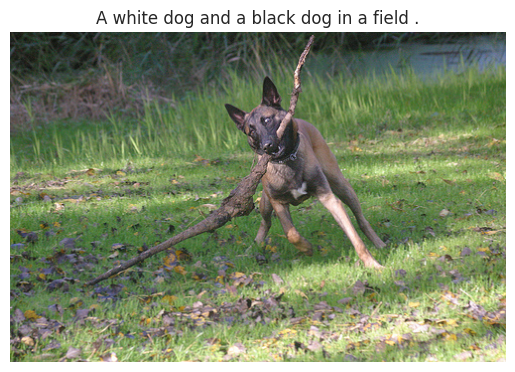

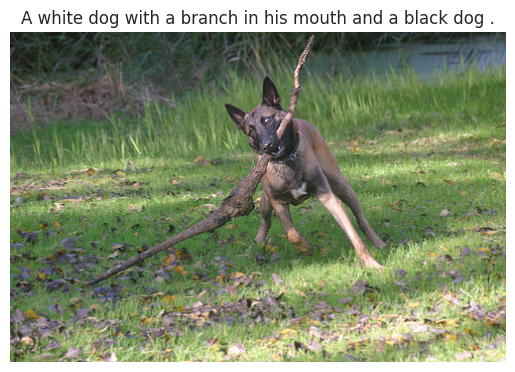

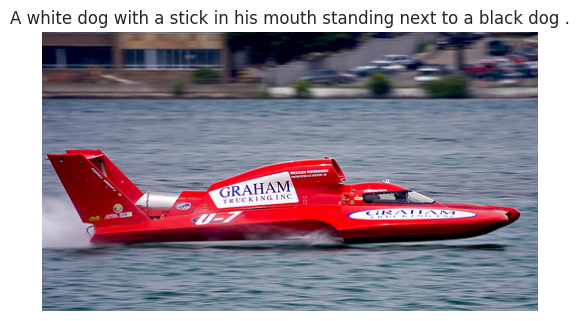

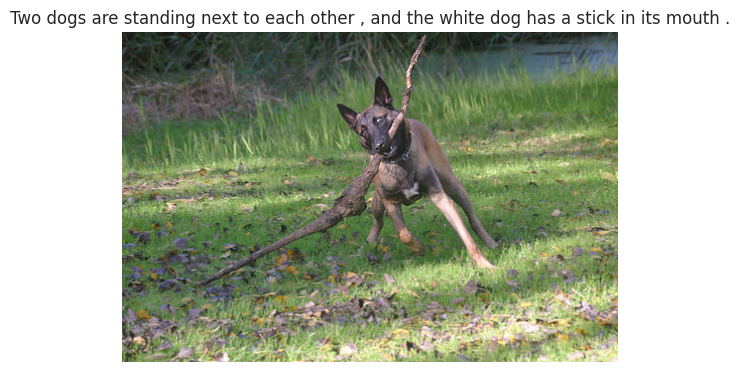

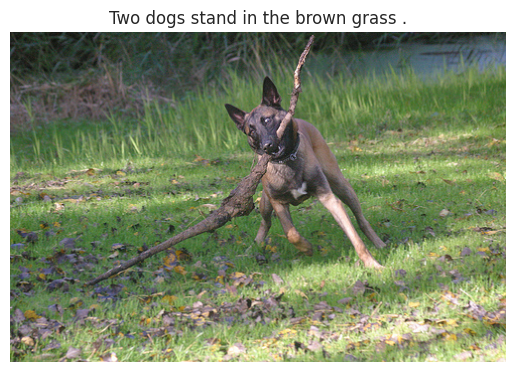

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [76]:
for i in range(20,30):
    query = test_queries['query_text'].loc[i]
    find_image(query, best_config_name = best_config_name)

Создали функцию,которая на вход принимает описание и по данному описанию ищет максимальное соответствие в картинках из тестовой папки.

Проверили модель на 10 текстовых запросах.
При запросе, который содержит что-то связанное с детьми, выдается дисклеймер "This image is unavailable in your country in compliance with local laws."

В других случаях показана картинка. Метрики модели не высоки, в связи с этим модель можно улучшать и тогда соответсвие картинок также улучшится.

Так как нейронная сеть справляется с задачей не очень удачно, опробуем нейронную сеть CLIP от OPEN AI. Ее преимущества в том, что ее не нужно обучать и она дает очень хорошие результаты.

In [77]:
logging.getLogger('sentence_transformers').setLevel(logging.WARNING)
torch.set_num_threads(1)  # Уменьшаем использование CPU

# 2. Тихая загрузка модели
model = SentenceTransformer('clip-ViT-B-32', device='cpu')
# Кэш для хранения эмбеддингов изображений (ускоряет повторные поиски)
image_embeddings_cache = {}

def find_image_clip(query, image_folder, banned_words=None, threshold=0.25):
    """
    Находит и показывает только финальное изображение без промежуточного вывода
    
    Параметры:
        query: текстовый запрос
        image_folder: путь к папке с изображениями
        banned_words: список запрещенных слов
        threshold: минимальный порог схожести (0-1)
    
    Возвращает:
        Путь к изображению или None, если не найдено
    """
    # Инициализация модели (первый вызов будет медленным)
    if not hasattr(find_image_clip, 'model'):
        find_image_clip.model = SentenceTransformer('clip-ViT-B-32')
    
    # Проверка запрещенных слов
    if banned_words and any(bad_word.lower() in query.lower() for bad_word in banned_words):
        print("This image is unavailable in your country in compliance with local laws.")
        return None
    
    # Получаем список изображений
    try:
        image_files = [f for f in os.listdir(image_folder) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
    except FileNotFoundError:
        return None
    
    if not image_files:
        return None
    
    # Кодируем текстовый запрос
    text_embedding = find_image_clip.model.encode(query, convert_to_tensor=True)
    
    best_image = None
    max_similarity = threshold
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        
        # Используем кэш эмбеддингов
        if img_path not in image_embeddings_cache:
            try:
                img = Image.open(img_path)
                image_embeddings_cache[img_path] = find_image_clip.model.encode(img, convert_to_tensor=True)
            except:
                continue
        
        # Вычисляем схожесть
        similarity = util.pytorch_cos_sim(text_embedding, image_embeddings_cache[img_path]).item()
        
        if similarity > max_similarity:
            max_similarity = similarity
            best_image = img_path
    
    # Показываем результат (если найден)
    if best_image:
        plt.figure(figsize=(10, 6))
        plt.title(query)
        plt.imshow(Image.open(best_image))
        plt.axis('off')
        plt.show()
        return best_image
    
    return None

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

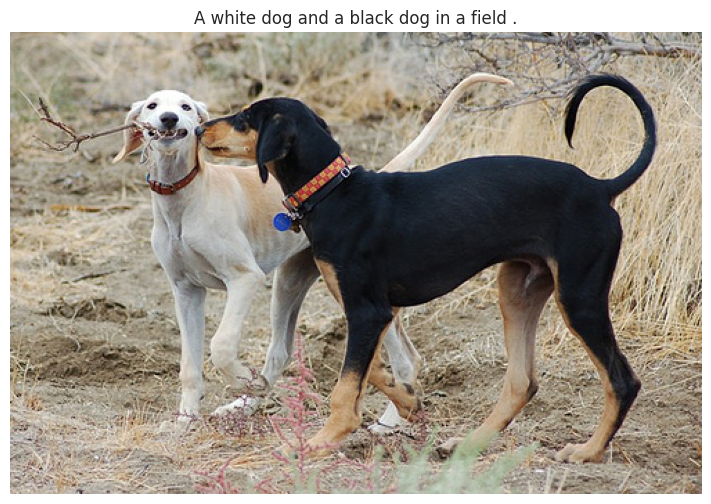

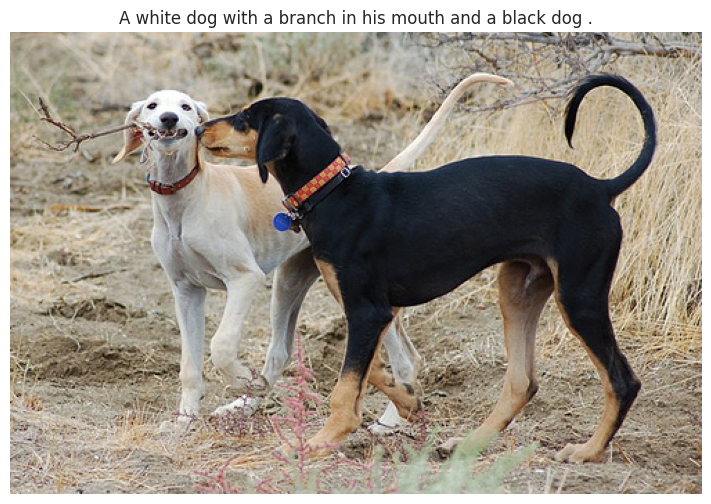

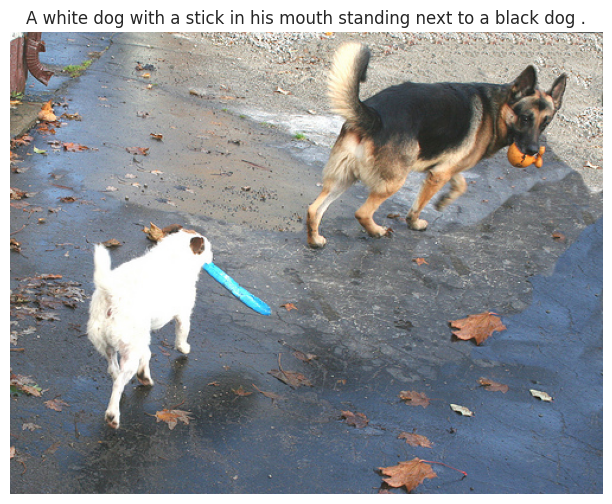

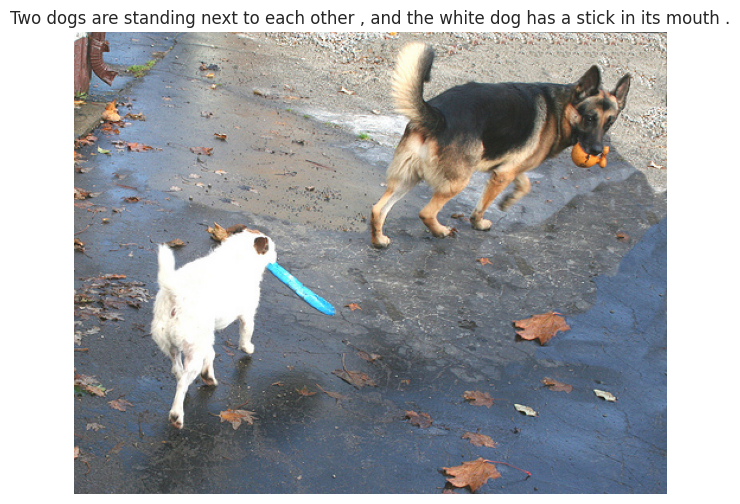

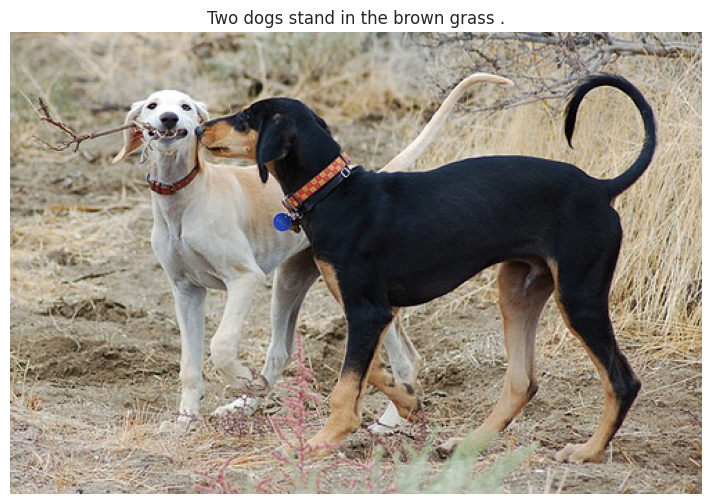

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [78]:
for i in range(20, 30):
    query = test_queries['query_text'].loc[i]
    find_image_clip(query, image_folder_test, banned_words = banned_words)

По визуальному тестированию видно, что нейронная сеть CLIP от OPEN AI справляется гораздо лучше, чем построенная полносвязная нейронная сеть. И сложная обработка данных не требуется.